In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
N = 100

x0 = np.array([0, 0], dtype=np.int32)

params = np.array([1,         # k_rna: mRNA production rate
                   50,        # k_protein: protein production rate
                   1/5,       # g_rna: mRNA degradation rate
                   1/30],     # p_protein: protein degradation rate
            dtype=np.float32)

reactions = np.array([[1, 0],    # + mRNA
                      [-1, 0],   # - mRNA
                      [0, 1],    # + Protein
                      [0, -1]],  # - Protein
                dtype=np.int32)

t_max = 200

dt_reg = 0.1

In [3]:
@jit
def central_dogma(x, params):

    rna, protein = x
    
    k_rna =     params[0]
    k_protein = params[1]
    g_rna =     params[2]
    g_protein = params[3]

    propensities = np.empty(4, dtype=np.float32)
    propensities[0] = k_rna
    propensities[1] = rna*g_rna
    propensities[2] = rna*k_protein
    propensities[3] = protein*g_protein

    Stot = propensities.sum()
    U = np.random.rand()
    Tau = np.random.exponential(1/Stot)

    s = 0
    while s < propensities.size:
        if U < propensities[:s+1].sum()/Stot:
            return Tau, s
        s += 1

In [4]:
@jit
def pop_sim(N=N, x0=x0, params=params, reactions=reactions, t_max=t_max, dt_reg=dt_reg):

    t_size = round(t_max/dt_reg)
    time = np.zeros(t_size, dtype=np.float32)
    pop = np.zeros((N, x0.size, t_size), dtype=np.int32)
    pop[:, :, 0] = x0.copy()

    cell = 0
    while cell < N:
        t = 0
        x = x0.copy()
        i = 1
        while i < t_size:
            t_i = i*dt_reg
            while t < t_i:
                Tau, j = central_dogma(x, params)
                x += reactions[j]
                t += Tau
            pop[cell, :, i] = x
            time[i] = t_i
            i += 1
        cell += 1

    return pop, time

In [5]:
@jit
def regularized_pop_stats(pop, time, ss=-1):
    N = pop.shape[0]
    t_size = time.size
    
    rna_mean = np.zeros(t_size, dtype=np.float64)
    rna_std = np.zeros(t_size, dtype=np.float64)
    protein_mean = np.zeros(t_size, dtype=np.float64)
    protein_std = np.zeros(t_size, dtype=np.float64)

    for t in range(t_size):
        pop_r = np.zeros(N, dtype=np.int32)
        pop_p = np.zeros(N, dtype=np.int32)
        for n in range(N):
            pop_r[n] = pop[n][0][t]
            pop_p[n] = pop[n][1][t]
        rna_mean[t] = pop_r.mean()
        rna_std[t] = pop_r.std()
        protein_mean[t] = pop_p.mean()
        protein_std[t] = pop_p.std()
    
    rna_ss = np.zeros(N, dtype=np.int32)
    protein_ss = np.zeros(N, dtype=np.int32)
    for n in range(N):
        rna_ss[n] = pop[n][0][ss]
        protein_ss[n] = pop[n][1][ss]
    rna_ss_mean = rna_ss.mean()
    rna_ss_noise = rna_ss.std()/rna_ss_mean
    protein_ss_mean = protein_ss.mean()
    protein_ss_noise = protein_ss.std()/protein_ss_mean

    return rna_mean, rna_std, protein_mean, protein_std, rna_ss, protein_ss, rna_ss_mean, rna_ss_noise, protein_ss_mean, protein_ss_noise

In [7]:
pop, time = pop_sim()
rna_mean, rna_std, protein_mean, protein_std, rna_ss, protein_ss, rna_ss_mean, rna_ss_noise, protein_ss_mean, protein_ss_noise = regularized_pop_stats(pop, time)

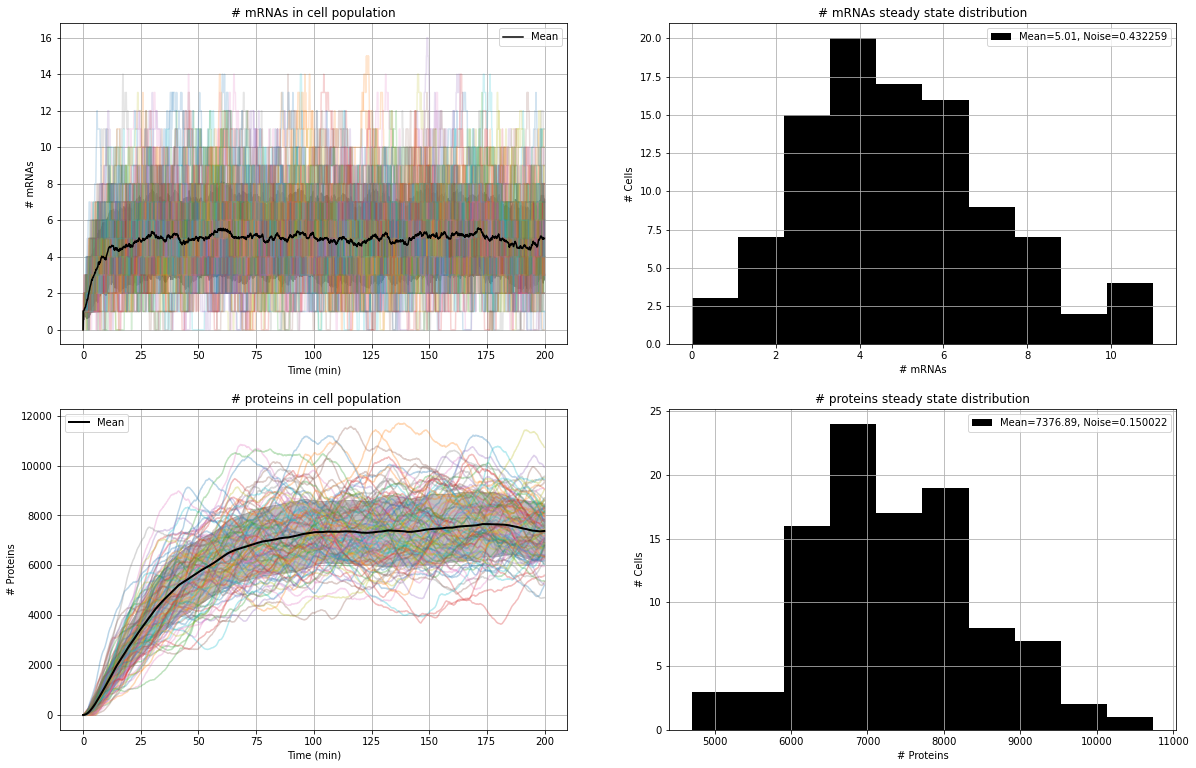

In [8]:
plt.figure(figsize=(20,13))
plt.subplot(2,2,1)
for cell in pop:
    plt.plot(time, cell[0], alpha=0.2)
plt.plot(time, rna_mean, c='k', label='Mean')
plt.fill_between(time, rna_mean-rna_std, rna_mean+rna_std, color='gray', alpha=0.9)
plt.legend(loc=0)
plt.xlabel('Time (min)')
plt.ylabel('# mRNAs')
plt.title('# mRNAs in cell population')
plt.grid()
plt.subplot(2,2,2)
plt.hist(rna_ss, color='k', label=f'Mean={rna_ss_mean}, Noise={rna_ss_noise:2f}')
plt.legend(loc=0)
plt.xlabel('# mRNAs')
plt.ylabel('# Cells')
plt.title('# mRNAs steady state distribution')
plt.grid()
plt.subplot(2,2,3)
for cell in pop:
    plt.plot(time, cell[1], alpha=0.3)
plt.plot(time, protein_mean, c='k', label='Mean', linewidth=2)
plt.fill_between(time, protein_mean-protein_std, protein_mean+protein_std, color='gray', alpha=0.5)
plt.legend(loc=0)
plt.xlabel('Time (min)')
plt.ylabel('# Proteins')
plt.title(' # proteins in cell population')
plt.grid()
plt.subplot(2,2,4)
plt.hist(protein_ss, color='k', label=f'Mean={protein_ss_mean}, Noise={protein_ss_noise:2f}')
plt.legend(loc=0)
plt.xlabel('# Proteins')
plt.ylabel('# Cells')
plt.title('# proteins steady state distribution')
plt.grid()
plt.show()